In [1]:
import h5py

In [2]:
import logging
import time
from platform import python_version
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [3]:
import transformers

In [4]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased',)
dbert_model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [5]:
max_seq = 98

In [6]:
with h5py.File('./LIAR_dataset/hidden_features.hdf5', 'r') as f:
    data = f.get('default').value
with h5py.File('./LIAR_dataset/test_features.hdf5', 'r') as g:
    test_data = g.get('default').value

In [7]:
def read_data(filename):
    df = pd.read_csv(filename,engine='python', delimiter=r'\t+', names=['id', 'Label','Statement', 'subject', 'speaker','speaker_title','state', 'party','barely_true','false_counts','half_true','mostly_true','pants_on_fire','context'])
    labels=[]
    for l in df['Label']:
        if l in ['false','barely-true','pants-fire']:
            temp = [1,0]
            labels.append(temp)
        elif l in ['half-true','mostly-true', 'true']:
            temp = [0, 1]
            labels.append(temp)
        else:
            raise Exception("Error encountered in labelling")
    data = pd.concat([df['Statement'], pd.Series(labels)], axis=1)
    data.columns = ['Statement', 'Label']
    return data

In [52]:
data_train = read_data('LIAR_dataset/train.tsv')
data_test = read_data('LIAR_dataset/test.tsv')
data_valid = read_data('LIAR_dataset/valid.tsv')
data_train = pd.concat([data_train, data_valid])


train_labels = data_train['Label'].values
test_labels = data_test['Label'].values

In [53]:
train_labels

array([list([1, 0]), list([0, 1]), list([0, 1]), ..., list([0, 1]),
       list([1, 0]), list([1, 0])], dtype=object)

In [54]:
from sklearn.model_selection import train_test_split


In [55]:
train_labels = np.array([np.array(xi) for xi in train_labels])
test_labels = np.array([np.array(xi) for xi in test_labels])

In [56]:
#full_features
x_train, x_val, y_train, y_val = train_test_split(data, train_labels)

In [57]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [58]:
x_test =  torch.tensor(test_data, dtype=torch.float32)

In [59]:
y_test = torch.tensor(test_labels, dtype=torch.float32)

In [60]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        if self.static:
            x = Variable(x)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
#         mylist=[]
#         for conv in self.convs1:
#             op1 = conv(x)
#             op2 = F.relu(op1).squeeze(3)
#             mylist.append(mylist)
#         x = torch.Tensor(np.array(mylist))
#         x = [print(conv(x)) for conv in self.convs1]
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [61]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [65]:
n_epochs = 20
batch_size = 32
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [66]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [67]:
import argparse

In [68]:
# Load saved model if needed

# model.load_state_dict(torch.load('./model_weights/idfsbert_32_valid_0.640900364943913'))

In [69]:
train_losses, val_losses = [], []
count=0
for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
#         y_batch = y_batch.unsqueeze(1)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
#             y_batch = y_batch.unsqueeze(1)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )
#     if abs(train_losses[-1] - val_losses[-1]) <= 0.01:
#         torch.save(model.state_dict(), './model_weights/idfsbert_32_valid' + str(val_losses[-1]))
#         print('model saved')
#         count=0
#     else:
#         count+=1
#         if count>=5:
#             break

Epoch 1 Train loss: 0.68. Validation loss: 0.67. Elapsed time: 8.27s.
Epoch 2 Train loss: 0.67. Validation loss: 0.66. Elapsed time: 7.88s.
Epoch 3 Train loss: 0.66. Validation loss: 0.65. Elapsed time: 9.22s.
Epoch 4 Train loss: 0.65. Validation loss: 0.66. Elapsed time: 7.61s.
Epoch 5 Train loss: 0.65. Validation loss: 0.65. Elapsed time: 8.00s.
Epoch 6 Train loss: 0.64. Validation loss: 0.65. Elapsed time: 7.78s.
Epoch 7 Train loss: 0.64. Validation loss: 0.65. Elapsed time: 8.72s.
Epoch 8 Train loss: 0.64. Validation loss: 0.65. Elapsed time: 7.99s.
Epoch 9 Train loss: 0.63. Validation loss: 0.65. Elapsed time: 7.55s.
Epoch 10 Train loss: 0.63. Validation loss: 0.65. Elapsed time: 8.37s.
Epoch 11 Train loss: 0.62. Validation loss: 0.65. Elapsed time: 8.14s.
Epoch 12 Train loss: 0.61. Validation loss: 0.65. Elapsed time: 8.51s.
Epoch 13 Train loss: 0.61. Validation loss: 0.65. Elapsed time: 7.49s.
Epoch 14 Train loss: 0.60. Validation loss: 0.66. Elapsed time: 7.91s.
Epoch 15 Train 

In [70]:
import matplotlib.pyplot as plt

In [72]:
model.eval()

KimCNN(
  (embed): Embedding(98, 768)
  (convs1): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [73]:
with torch.no_grad():
    y_pred = model(x_test)

In [74]:
loss = loss_fn(y_pred, y_test)
test_loss = loss.item()

In [75]:
from sklearn.metrics import precision_recall_fscore_support,classification_report


In [76]:
y2=[]
for q in y_pred:
    if(q[0]>0.5):
        y2.append(True)
    else:
        y2.append(False)

y_test_truth=[]
for p in test_labels:
    if(p[0]>0.5):
        y_test_truth.append(True)
    else:
        y_test_truth.append(False)

print('Classification report:\n',classification_report(y_test_truth,y2))

Classification report:
               precision    recall  f1-score   support

       False       0.68      0.64      0.66       727
        True       0.56      0.61      0.58       556

   micro avg       0.62      0.62      0.62      1283
   macro avg       0.62      0.62      0.62      1283
weighted avg       0.63      0.62      0.63      1283



In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_truth, y2)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[462 265]
 [217 339]]


In [78]:
acc = (cm[0][0] + cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])

print('Accuracy: ' + str(acc))

Accuracy: 0.6243180046765393


Text(0.5, 1.0, 'Losses')

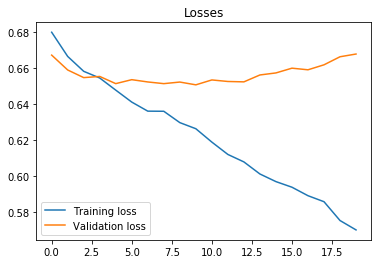

In [71]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

# Multi class classfication